# Chunking

Demo tutorial for how to use nlp_toolkit to train sequence labeling model and predict new samples. The task we choose is noun phrases labeling.

The dataset includes working experience texts from different cv, and we want to label noun phrases in given text.

Available models:

1. WordRNN
2. CharRNN
3. IDCNN

In [1]:
from nlp_toolkit import Dataset, Labeler

/opt/wangyilei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
2018-12-19 09:59:46,198 - __init__.py[line:24] - INFO: Choose the most free GPU: 0, currently not support multi-gpus


## Data Processing

### Load config dict

In [2]:
import yaml
config = yaml.safe_load(open('../config_sequence_labeling.yaml'))
config['data']['inner_char'] = True
config['embed']['pre'] = True
# if we want to use pre_trained embeddings, we need a gensim-format embedding file
config['embed']['word']['path'] = '../data/embeddings/tencent_np_200d.txt'

### Load data

if you are using pre-trained embeddings, the oov rate should not be over 5%

In [3]:
dataset = Dataset(fname='../data/cv_word.txt', task_type='sequence_labeling', mode='train', config=config)

2018-12-19 09:59:59,208 - data.py[line:159] - INFO: data loaded
2018-12-19 10:00:04,250 - data.py[line:267] - INFO: transformer fitting complete
2018-12-19 10:00:09,456 - utilities.py[line:254] - INFO: OOV rate: 0.25 %
2018-12-19 10:00:09,487 - data.py[line:273] - INFO: Loaded Pre_trained Embeddings


In [4]:
for x, y in zip(dataset.texts['token'][0:10], dataset.labels[0:10]):
    print(list(zip(x, y)))

[('主要', 'O'), ('帮助', 'O'), ('工地', 'B-Chunk'), ('师傅', 'E-Chunk'), ('一起', 'O'), ('超平', 'O'), (',', 'O'), ('防线', 'O'), ('工作', 'O')]
[('协助', 'O'), ('线', 'O'), ('上', 'O'), ('、', 'O'), ('线', 'B-Chunk'), ('下', 'I-Chunk'), ('活动', 'E-Chunk'), ('的', 'O'), ('执行', 'O')]
[('执行', 'O'), ('各项', 'O'), ('培训', 'O'), ('相关', 'O'), ('的', 'O'), ('各项', 'O'), ('工作', 'B-Chunk'), ('流程', 'E-Chunk')]
[('云南', 'O'), (':', 'O'), ('曲靖', 'O'), ('、', 'O'), ('昭通', 'O'), ('下属', 'O'), ('的', 'O'), ('5', 'O'), ('个', 'O'), ('县级', 'O'), ('供电', 'B-Chunk'), ('公司', 'E-Chunk'), ('10', 'O'), ('个', 'O'), ('供电所', 'O')]
[('担任', 'O'), ('培训', 'O'), ('学校', 'B-Chunk'), ('英语', 'I-Chunk'), ('讲师', 'E-Chunk'), ('一', 'O'), ('职', 'O'), ('和', 'O'), ('学生', 'B-Chunk'), ('管理', 'E-Chunk')]
[('搜寻', 'O'), ('招标', 'B-Chunk'), ('公告', 'E-Chunk'), (',', 'O'), ('告知', 'O'), ('领导', 'O'), ('及', 'O'), ('业务', 'B-Chunk'), ('人员', 'E-Chunk'), (',', 'O'), ('确认', 'O'), ('是否', 'O'), ('报名', 'O')]
[('2001', 'O'), ('/', 'O'), ('10', 'O'), ('--', 'O'), ('2002', 'O'), ('/'

if your want to see the vocab and label index mapping dict

In [5]:
# dataset.transformer._word_vocab._token2id

In [6]:
# dataset.transformer._label_vocab._token2id

## Chunking Labeling

### Define Sequence Labeler

avialiable models: model_name_list = ['word_rnn', 'char_rnn', 'idcnn']

In [5]:
model_name='word_rnn'

In [8]:
seq_labeler = Labeler(model_name=model_name, dataset=dataset, seq_type='bucket')

### Train model

In [9]:
trained_model, history = seq_labeler.train()

2018-12-19 09:23:58,965 - trainer.py[line:124] - INFO: word_rnn model structure...
2018-12-19 09:23:58,994 - trainer.py[line:136] - INFO: train/valid set: 45932/11483
2018-12-19 09:23:58,995 - trainer.py[line:93] - INFO: use bucket sequence to speed up model training
2018-12-19 09:23:59,002 - sequence.py[line:355] - INFO: Training with 77 non-empty buckets
2018-12-19 09:23:59,164 - sequence.py[line:355] - INFO: Training with 77 non-empty buckets


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char (InputLayer)               (None, None, None)   0                                            
__________________________________________________________________________________________________
token (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, None, 3 114016      char[0][0]                       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    7934600     token[0][0]                      
__________________________________________________________________________________________________
char_cnn (

2018-12-19 09:24:00,042 - trainer.py[line:168] - INFO: saving model parameters and transformer to models/word_rnn_201812190923


model hyperparameters:
 {'nb_classes': 4, 'nb_tokens': 39673, 'maxlen': None, 'embedding_dim': 200, 'rnn_type': 'lstm', 'nb_rnn_layers': 2, 'drop_rate': 0.5, 're_drop_rate': 0.15, 'use_crf': True, 'inner_char': True, 'word_rnn_size': 128, 'embed_dropout_rate': 0.15, 'integration_method': 'attention', 'char_feature_method': 'cnn', 'max_charlen': 10, 'nb_char_tokens': 3563, 'char_embedding_dim': 32, 'nb_filters': 200, 'conv_kernel_size': 2}
Epoch 1/25
757/757 [==============================] - 219s 290ms/step - loss: 2.5565 - acc: 0.8711 - val_loss: 2.5632 - val_acc: 0.9221
 - acc: 76.78
 - f1: 80.17
             precision    recall  f1-score   support

      Chunk       0.91      0.72      0.80      1989

avg / total       0.91      0.72      0.80      1989


Epoch 00001: f1_seq improved from -inf to 0.80169, saving model to models/word_rnn_201812190923/model_weights_01_0.9221_0.8017.h5
Epoch 2/25
757/757 [==============================] - 224s 296ms/step - loss: 2.7272 - acc: 0.9247 - 

### plot acc and loss

In [10]:
from nlp_toolkit import visualization as vs

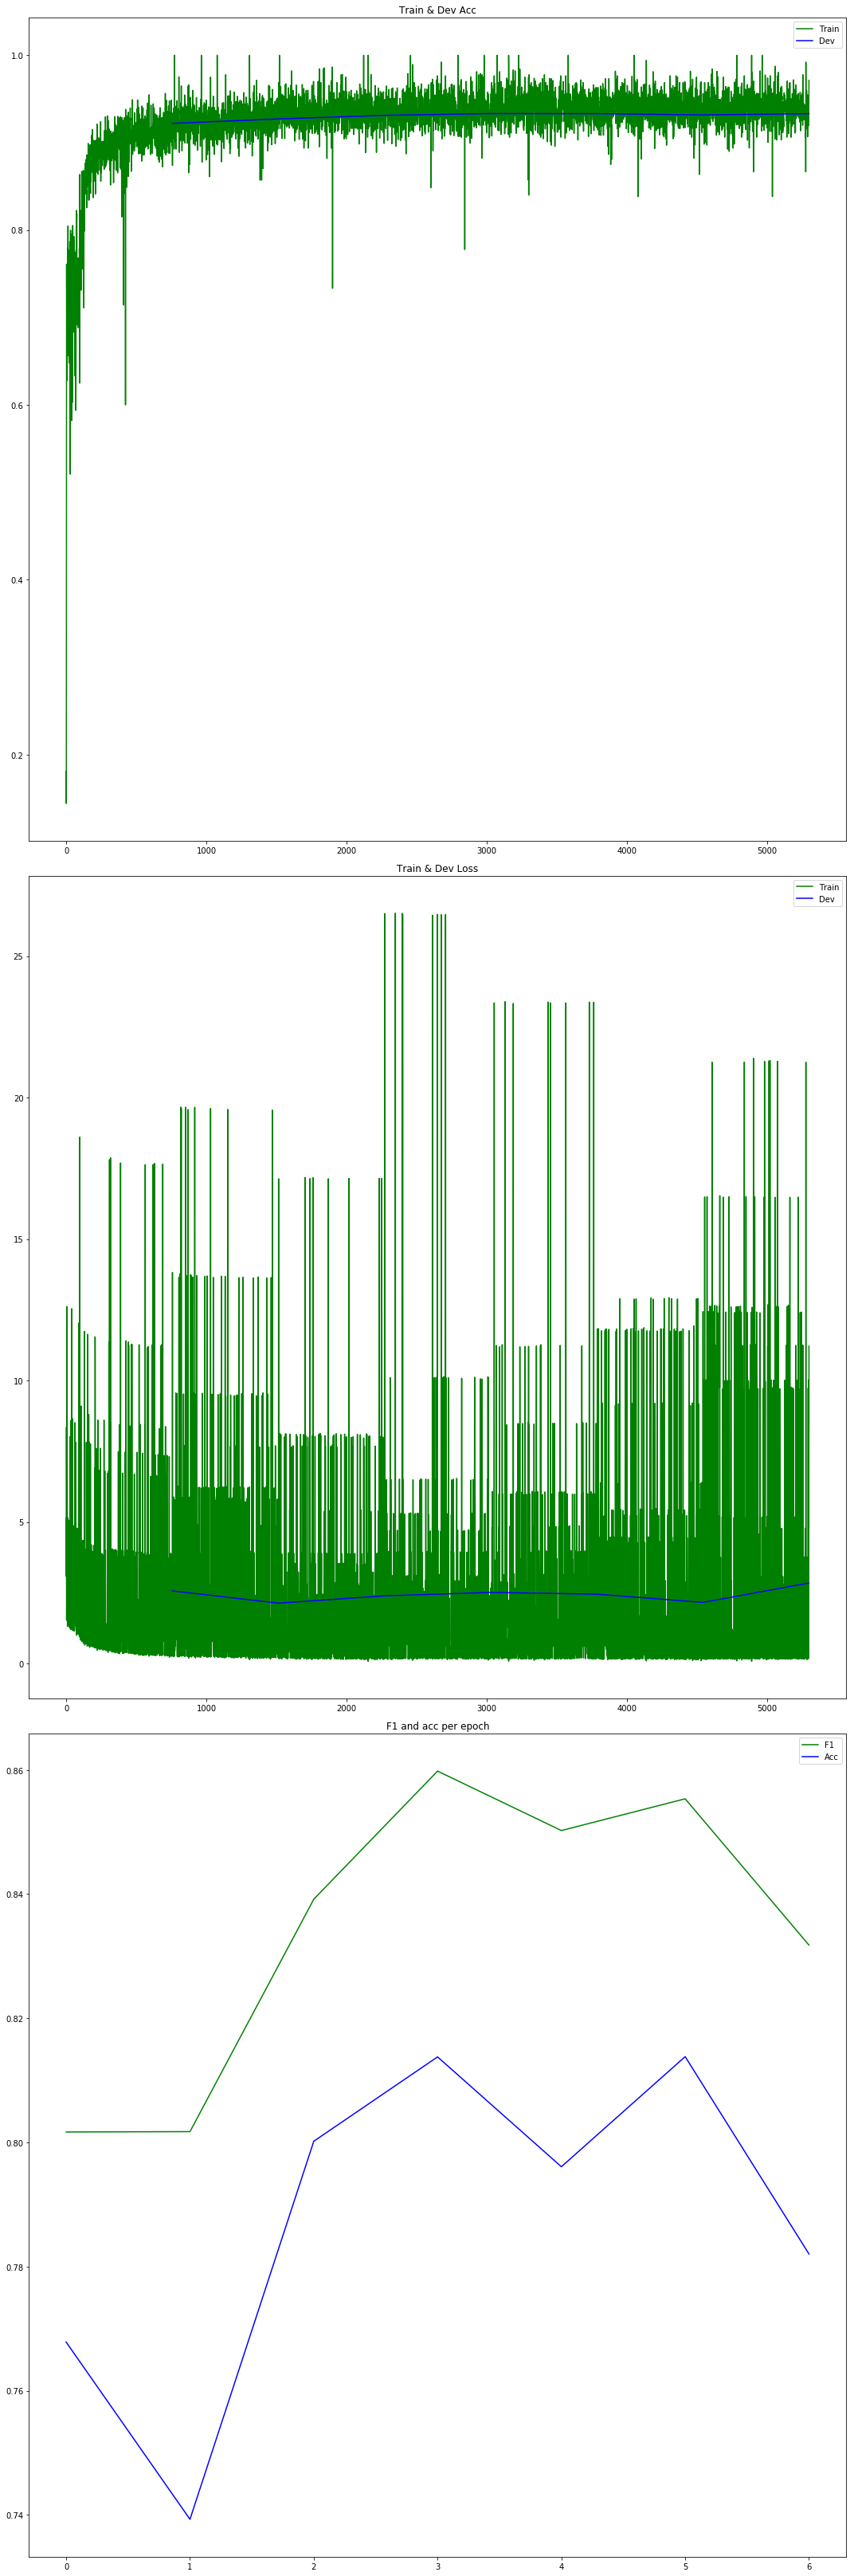

In [13]:
vs.plot_loss_acc(history, 'sequence_labeling')

### 10-fold training

In [6]:
config['train']['train_mode'] = 'fold'
seq_labeler_new = Labeler(model_name=model_name, dataset=dataset, seq_type='bucket')
seq_labeler_new.train()

2018-12-19 10:00:33,396 - trainer.py[line:189] - INFO: 10-fold starts!



------------------------ fold 0------------------------


2018-12-19 10:00:35,085 - trainer.py[line:203] - INFO: word_rnn model structure...
2018-12-19 10:00:35,090 - trainer.py[line:93] - INFO: use bucket sequence to speed up model training
2018-12-19 10:00:35,098 - sequence.py[line:355] - INFO: Training with 77 non-empty buckets
2018-12-19 10:00:35,267 - sequence.py[line:355] - INFO: Training with 77 non-empty buckets


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char (InputLayer)               (None, None, None)   0                                            
__________________________________________________________________________________________________
token (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, None, 3 114016      char[0][0]                       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    7934600     token[0][0]                      
__________________________________________________________________________________________________
char_cnn (

2018-12-19 10:34:31,672 - trainer.py[line:93] - INFO: use bucket sequence to speed up model training
2018-12-19 10:34:31,677 - sequence.py[line:355] - INFO: Training with 77 non-empty buckets
2018-12-19 10:34:31,842 - sequence.py[line:355] - INFO: Training with 77 non-empty buckets


mointor training process using f1 score and label acc
using Early Stopping
using Reduce LR On Plateau
tracking loss history and metrics
Epoch 1/25
844/844 [==============================] - 247s 293ms/step - loss: 3.4853 - acc: 0.7048 - val_loss: 2.8412 - val_acc: 0.7464
 - acc: 1.33
 - f1: 0.15
             precision    recall  f1-score   support

      Chunk       0.02      0.00      0.00      1260

avg / total       0.02      0.00      0.00      1260

Epoch 2/25
426/844 [==============>...............] - ETA: 1:50 - loss: 3.3714 - acc: 0.7185

KeyboardInterrupt: 

## Predict New Samples

### Load data and transformer

In [7]:
dataset = Dataset(fname='../data/cv_word_predict.txt',
                  task_type='sequence_labeling', mode='predict',
                  tran_fname='models/word_rnn_201812171047/transformer.h5')

2018-12-19 10:40:59,880 - data.py[line:123] - INFO: transformer loaded
2018-12-19 10:41:00,467 - data.py[line:159] - INFO: data loaded


### Load model

In [8]:
seq_labeler = Labeler('word_rnn', dataset)
seq_labeler.load(weight_fname='models/word_rnn_201812171047/model_weights_05_0.9339_0.8622.h5',
                 para_fname='models/word_rnn_201812171047/model_parameters.json')

model loaded


### predict samples

In [9]:
# if you want to get the label probability of each tokens, set return_prob as True
# if you don't want to use Dataset class to generate some other features or clean texts (not recommend)
# just make one fake dict with one key "token" and the value is the nested list of words
y_pred = seq_labeler.predict(dataset.texts, return_prob=False)

2018-12-19 10:43:10,838 - labeler.py[line:141] - INFO: predict 57415 samples used 120.9s


In [10]:
# more pretty result prediction
print([(x1, y1) for x1, y1 in zip(dataset.texts['token'][0], y_pred[0])])

[('主要', 'O'), ('帮助', 'O'), ('工地', 'B-Chunk'), ('师傅', 'E-Chunk'), ('一起', 'O'), ('超平', 'O'), (',', 'O'), ('防线', 'O'), ('工作', 'O')]


In [13]:
# more more pretty result prediction --> it will create a new html file, you need open it in a browser
from nlp_toolkit import visualization as vs
vs.entity_visualization(dataset.texts['token'], y_pred)

### Evaluate model

In [14]:
dataset = Dataset(mode='eval', fname='../data/cv_word_basic.txt',
                  task_type='sequence_labeling',
                  tran_fname='models/word_rnn_201812182341/transformer.h5',
                  data_format='basic')
seq_labeler = Labeler('word_rnn', dataset)
seq_labeler.load(weight_fname='models/word_rnn_201812182341/model_weights_02_0.9286_0.8590.h5',
                     para_fname='models/word_rnn_201812182341/model_parameters.json')

# if you don't want to use Dataset class to generate some other features or clean texts (not recommend)
# just make one fake dict with one key "token" and the value is the nested list of words.
seq_labeler.evaluate(dataset.texts, dataset.labels)

2018-12-19 10:45:06,301 - data.py[line:123] - INFO: transformer loaded
2018-12-19 10:45:06,597 - data.py[line:159] - INFO: data loaded


model loaded
             precision    recall  f1-score   support

      Chunk       0.83      0.88      0.86        34

avg / total       0.83      0.88      0.86        34

